In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import psycopg2

from sklearn.preprocessing import LabelEncoder

In [2]:
conn = psycopg2.connect(dbname='COMPG011', host='127.0.0.1', user='postgres', password='password')
cur = conn.cursor()

In [3]:
cur.execute('''SELECT a.total_kills, 
                      a.total_deaths, 
                      a.total_time_played,
                      a.total_kills_headshot, 
                      a.total_shots_hit, 
                      a.total_mvps, 
                      a.total_wins,
                      a.total_rounds_played,
                      a.total_shots_fired,
                      a.rank_id,
                      a.goal_id,
                      b.sniper,
                      b.assault,
                      b.support,
                      b.captain,
                      b.strategy,
                      d.other AS weap_other,
                      d.pistol AS weap_pistol,
                      d.submachine AS weap_submachine,
                      d.shotgun AS weap_shotgun,
                      d.sniper AS weap_sniper,
                      d.assault AS weap_assault,
                      d.grenade AS weap_grenade,
                      e.receive_emails,
                      e.country,
                      e.gender,
                      e.birthday
                FROM csgo.profiles a,
                     
                     (SELECT profile_id,
                             COUNT(CASE WHEN role_id = 1 THEN 1 END) AS sniper,
                             COUNT(CASE WHEN role_id = 2 THEN 1 END) AS assault,
                             COUNT(CASE WHEN role_id = 3 THEN 1 END) AS support,
                             COUNT(CASE WHEN role_id = 4 THEN 1 END) AS captain,
                             COUNT(CASE WHEN role_id = 5 THEN 1 END) AS strategy
                     FROM games.profiles_roles
                     GROUP BY profile_id) b,
                     
                     core.profiles c,
                     core.users e,
                     
                     (SELECT user_id,
                      SUM(total_kills * other) AS other,
                      SUM(total_kills * pistol) AS pistol,
                      SUM(total_kills * submachine) AS submachine,
                      SUM(total_kills * shotgun) AS shotgun,
                      SUM(total_kills * sniper) AS sniper,
                      SUM(total_kills * assault) AS assault,
                      SUM(total_kills * grenade) AS grenade FROM
                       (SELECT user_id, SUM(total_kills) AS total_kills, other, pistol, submachine, shotgun, sniper, assault, grenade 
                       FROM(SELECT name,
                             COUNT(CASE WHEN name = 'taser' OR
                                             name = 'knife' THEN 1 END) AS other,
                             COUNT(CASE WHEN name = 'tec9' OR
                                             name = 'elite' OR
                                             name = 'fiveseven' OR
                                             name = 'glock' OR
                                             name = 'hkp2000' OR
                                             name = 'p250' OR
                                             name = 'deagle' THEN 1 END) AS pistol,
                             COUNT(CASE WHEN name = 'ump45' OR 
                                             name = 'p90' OR 
                                             name = 'bizon' OR 
                                             name = 'mac10' OR 
                                             name = 'mp9' OR
                                             name = 'mp7' THEN 1 END) AS submachine,
                             COUNT(CASE WHEN name = 'xm1014' OR
                                             name = 'nova' OR
                                             name = 'sawedoff' OR
                                             name = 'mag7' THEN 1 END) AS shotgun,
                             COUNT(CASE WHEN name = 'scar20' OR
                                             name = 'ssg08' OR
                                             name = 'awp' OR
                                             name = 'g3sg1' THEN 1 END) AS sniper,
                             COUNT(CASE WHEN name = 'sg556' OR
                                             name = 'aug' OR 
                                             name = 'ak47' OR
                                             name = 'famas' OR 
                                             name = 'galilar' OR 
                                             name = 'm4a1' OR
                                             name = 'm249' OR
                                             name = 'negev' THEN 1 END) AS assault,
                             COUNT(CASE WHEN name = 'hegrenade' OR
                                             name = 'molotov' THEN 1 END) AS grenade
                             FROM csgo.weapons
                             GROUP BY name) a,
                             csgo.weapons_stats b
                             WHERE a.name = b.weapon_name
                             GROUP BY user_id, other, pistol, submachine, shotgun, sniper, assault, grenade) c
                             GROUP BY c.user_id) d
                WHERE a.total_kills IS NOT NULL AND
                      a.total_deaths IS NOT NULL AND
                      a.total_time_played IS NOT NULL AND
                      a.total_kills_headshot IS NOT NULL AND 
                      a.total_shots_hit IS NOT NULL AND
                      a.total_mvps IS NOT NULL AND
                      a.total_wins IS NOT NULL AND
                      a.total_rounds_played IS NOT NULL AND
                      a.total_shots_fired IS NOT NULL AND
                      a.rank_id IS NOT NULL AND
                      b.profile_id = c.id AND
                      c.user_id = a.user_id AND
                      d.user_id = a.user_id AND
                      e.id = c.user_id''')

rows = cur.fetchall()
col_names = [desc.name for desc in cur.description]

df = pd.DataFrame(rows, columns = col_names, dtype=np.int64)

In [3]:
cur.execute('''SELECT a.total_kills, 
                      a.total_deaths, 
                      a.total_time_played,
                      a.total_kills_headshot, 
                      a.total_shots_hit, 
                      a.total_mvps, 
                      a.total_wins,
                      a.total_rounds_played,
                      a.total_shots_fired,
                      a.rank_id,
                      a.goal_id,
                      e.receive_emails,
                      e.country,
                      e.gender,
                      e.birthday
                FROM csgo.profiles a,                     
                     core.profiles c,
                     core.users e,                             
                     (SELECT user_id, sum(total_rounds) AS total_rounds 
                         FROM csgo.maps_stats
                         GROUP BY user_id) f
                WHERE a.total_kills IS NOT NULL AND
                      a.total_deaths IS NOT NULL AND
                      a.total_time_played IS NOT NULL AND
                      a.total_kills_headshot IS NOT NULL AND 
                      a.total_shots_hit IS NOT NULL AND
                      a.total_mvps IS NOT NULL AND
                      a.total_wins IS NOT NULL AND
                      a.total_rounds_played IS NOT NULL AND
                      a.total_shots_fired IS NOT NULL AND
                      a.rank_id IS NOT NULL AND
                      c.user_id = a.user_id AND
                      e.id = c.user_id AND
                      f.user_id = a.user_id AND
                      a.total_kills / 9 <= f.total_rounds AND
                      a.total_kills_headshot <= a.total_kills AND
                      a.total_kills_headshot < 4000000''')

rows = cur.fetchall()
col_names = [desc.name for desc in cur.description]

df_cleaned = pd.DataFrame(rows, columns = col_names, dtype=np.int64)

In [9]:
conn.rollback()

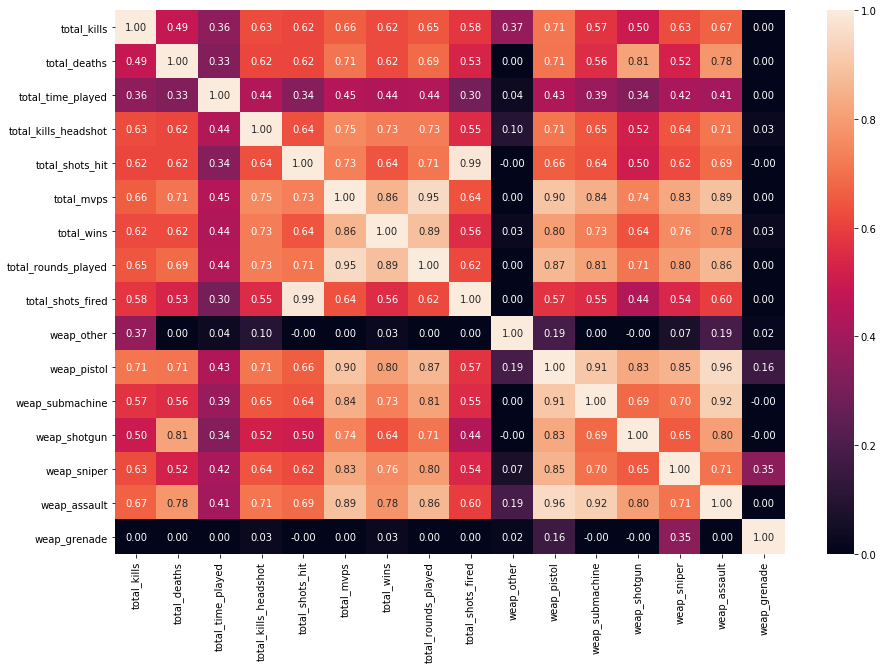

In [6]:
df_corr = df[['total_kills', 'total_deaths', 'total_time_played',
       'total_kills_headshot', 'total_shots_hit', 'total_mvps', 'total_wins',
       'total_rounds_played', 'total_shots_fired', 'weap_other',
       'weap_pistol', 'weap_submachine', 'weap_shotgun', 'weap_sniper',
       'weap_assault', 'weap_grenade']].corr('pearson')

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_corr, ax=ax, annot=True, annot_kws={"size": 10}, fmt=".2f")

plt.show()

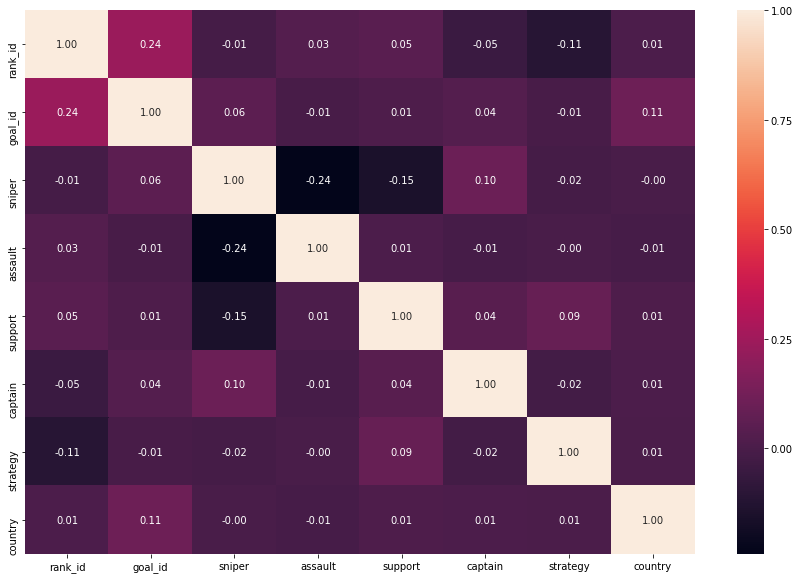

In [32]:
df_corr = df[['rank_id', 'goal_id', 'sniper', 'assault', 
              'support', 'captain', 'strategy', 'country']].corr('spearman')

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_corr, ax=ax, annot=True, annot_kws={"size": 10}, fmt=".2f")

plt.show()

### Hack merged ranks into data

In [4]:
# rank_id[1:6] = 1, rank_id[7:13], rank_id[14:18]
df_cleaned['merged_ranks'] = np.where(df_cleaned['rank_id'] < 7, np.full_like(df_cleaned['rank_id'], 1), df_cleaned['rank_id'])
df_cleaned['merged_ranks'] = np.where(np.logical_and(df_cleaned['rank_id'] > 6, df_cleaned['rank_id'] < 14), np.full_like(df_cleaned['rank_id'], 2), df_cleaned['merged_ranks'])
df_cleaned['merged_ranks'] = np.where(df_cleaned['rank_id'] > 13, np.full_like(df_cleaned['rank_id'], 3), df_cleaned['merged_ranks'])

df_cleaned['merged_ranks'].value_counts()



2    33939
3    24178
1    13812
Name: merged_ranks, dtype: int64

### Encode countries

In [5]:
le = LabelEncoder()
le.fit(df_cleaned['country'])
df_cleaned['country'] = le.transform(df_cleaned['country'])

### Create Ratios

In [6]:
df_cleaned['kd_ratio'] = df_cleaned['total_kills'] / df_cleaned['total_deaths']
df_cleaned['headshot_ratio'] = df_cleaned['total_kills_headshot'] / df_cleaned['total_kills']

### Plot correlation matrix for cleaned data

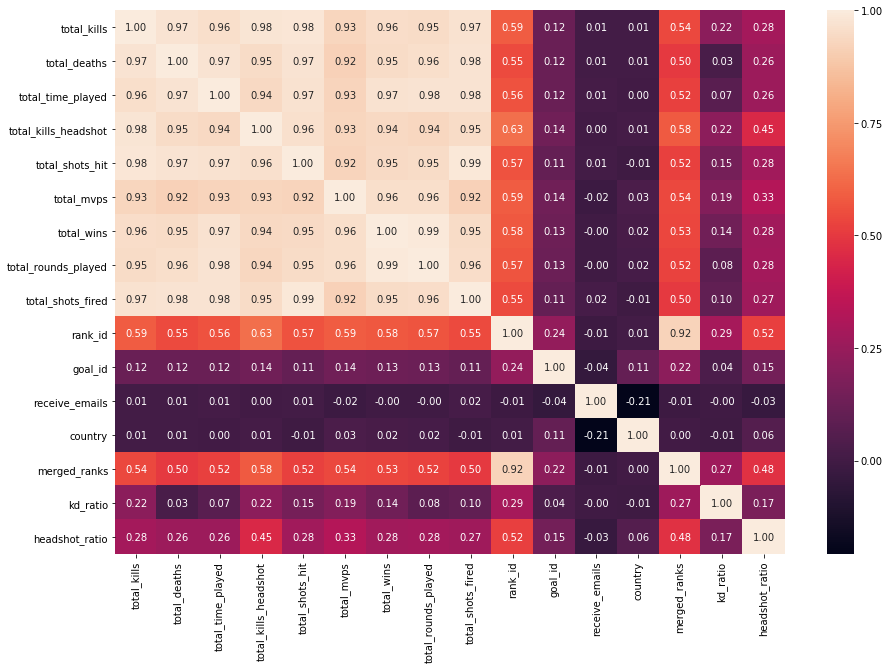

In [22]:
df_corr = df_cleaned.corr('spearman')

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_corr, ax=ax, annot=True, annot_kws={"size": 10}, fmt=".2f")

plt.show()

### Perform regression

In [25]:
df_cleaned.to_csv('data_cleaned.csv', index=False)

In [10]:
# Hack for statsmodels because the devs are lazy assholes
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [24]:
# Regression on MVPs
import statsmodels.api as sm
import statsmodels.tools as sm_tools
import statsmodels.discrete.discrete_model

df2 = sm_tools.add_constant(df_cleaned)
regr = statsmodels.discrete.discrete_model.MNLogit(
    exog=df2[['total_kills', 'total_deaths', 'total_time_played',
       'total_kills_headshot', 'total_shots_hit', 'total_mvps', 'total_wins',
       'total_rounds_played', 'total_shots_fired', 'headshot_ratio']], 
    endog=df2[['merged_ranks']])
results = regr.fit()
           

Optimization terminated successfully.
         Current function value: nan
         Iterations 3


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1673: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: invalid value encountered in true_divide
  return eXB/eXB.sum(1)[:,None]
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/statsmodels/base/optimizer.py:230: RuntimeWarning: invalid value encountered in greater
  oldparams) > tol)):


In [20]:
print(results.summary())

                          MNLogit Regression Results                          
Dep. Variable:           merged_ranks   No. Observations:                71929
Model:                        MNLogit   Df Residuals:                    71917
Method:                           MLE   Df Model:                           10
Date:                Sat, 10 Mar 2018   Pseudo R-squ.:                  0.1613
Time:                        14:15:03   Log-Likelihood:                -62605.
converged:                       True   LL-Null:                       -74644.
                                        LLR p-value:                     0.000
      merged_ranks=2       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
total_time_played     3.042e-10   9.78e-10      0.311      0.756   -1.61e-09    2.22e-09
total_shots_hit      -7.517e-09   5.29e-09     -1.421      0.155   -1.79e-08    2.85e-09
total_wins  

In [9]:
import sklearn.linear_model

mdl = sklearn.linear_model.Ridge(fit_intercept=True, normalize=True)
mdl.fit(df_cleaned[['total_kills', 'total_deaths', 'total_time_played',
       'total_kills_headshot', 'total_shots_hit', 'total_mvps', 'total_wins',
       'total_rounds_played', 'total_shots_fired', 'headshot_ratio']], df_cleaned['merged_ranks'])

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [11]:
mdl.score(df_cleaned[['total_kills', 'total_deaths', 'total_time_played',
       'total_kills_headshot', 'total_shots_hit', 'total_mvps', 'total_wins',
       'total_rounds_played', 'total_shots_fired', 'headshot_ratio']], df_cleaned['merged_ranks'])

0.29121984702911907

In [12]:
cls = sklearn.linear_model.RidgeClassifierCV(fit_intercept=True, normalize=True)
cls.fit(df_cleaned[['total_kills', 'total_deaths', 'total_time_played',
       'total_kills_headshot', 'total_shots_hit', 'total_mvps', 'total_wins',
       'total_rounds_played', 'total_shots_fired', 'headshot_ratio']], df_cleaned['merged_ranks'])

RidgeClassifierCV(alphas=(0.1, 1.0, 10.0), class_weight=None, cv=None,
         fit_intercept=True, normalize=True, scoring=None)

In [ ]:
cls.score()